# Setup

In [190]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
# from torch.autograd import Variable
import torch.autograd

import operator
from functools import reduce
from functools import partial

import numpy as np
import scipy.io
import h5py

import time
import matplotlib.pyplot as plt

In [191]:
#################################################
#
# Utilities
#
#################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# reading data
class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path, 'r')
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float

# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

# normalization, Gaussian
class GaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(GaussianNormalizer, self).__init__()

        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        x = (x * (self.std + self.eps)) + self.mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


# normalization, scaling by range
class RangeNormalizer(object):
    def __init__(self, x, low=0.0, high=1.0):
        super(RangeNormalizer, self).__init__()
        mymin = torch.min(x, 0)[0].view(-1)
        mymax = torch.max(x, 0)[0].view(-1)

        self.a = (high - low)/(mymax - mymin)
        self.b = -self.a*mymax + high

    def encode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = self.a*x + self.b
        x = x.view(s)
        return x

    def decode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = (x - self.b)/self.a
        x = x.view(s)
        return x

#loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

# A simple feedforward neural network
class DenseNet(torch.nn.Module):
    def __init__(self, layers, nonlinearity, out_nonlinearity=None, normalize=False):
        super(DenseNet, self).__init__()

        self.n_layers = len(layers) - 1

        assert self.n_layers >= 1

        self.layers = nn.ModuleList()

        for j in range(self.n_layers):
            self.layers.append(nn.Linear(layers[j], layers[j+1]))

            if j != self.n_layers - 1:
                if normalize:
                    self.layers.append(nn.BatchNorm1d(layers[j+1]))

                self.layers.append(nonlinearity())

        if out_nonlinearity is not None:
            self.layers.append(out_nonlinearity())

    def forward(self, x):
        for _, l in enumerate(self.layers):
            x = l(x)

        return x

# print the number of parameters
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, list(p.size()))
    return c

def compl_mul2d(a, b):
    # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
    return torch.einsum("bixy,ioxy->boxy", a, b)

In [192]:
class LowRank2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LowRank2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.phi = DenseNet([2, 64, 128, in_channels*out_channels], torch.nn.ReLU)
        self.psi = DenseNet([2, 64, 128, in_channels*out_channels], torch.nn.ReLU)

    def get_grid(self, S1, S2, batchsize, device):
        gridx = torch.tensor(np.linspace(0, 1, S1), dtype=torch.float)
        gridx = gridx.reshape(1, S1, 1).repeat([batchsize, 1, S2])
        gridy = torch.tensor(np.linspace(0, 1, S2), dtype=torch.float)
        gridy = gridy.reshape(1, 1, S2).repeat([batchsize, S1, 1])
        return torch.stack((gridx, gridy), dim=-1).to(device)

    def forward(self, x, gridy=None):
        # x (batch, channel, x, y)
        # y (Ny, 2)
        batchsize, size1, size2 = x.shape[0], x.shape[2], x.shape[3]

        gridx = self.get_grid(S1=size1, S2=size2, batchsize=1, device=x.device).reshape(size1 * size2, 2)
        if gridy==None:
            gridy = self.get_grid(S1=size1, S2=size2, batchsize=1, device=x.device).reshape(size1 * size2, 2)
        Nx = size1 * size2
        Ny = gridy.shape[0]

        phi_eval = self.phi(gridx).reshape(Nx, self.out_channels, self.in_channels)
        psi_eval = self.psi(gridy).reshape(Ny, self.out_channels, self.in_channels)
        x = x.reshape(batchsize, self.in_channels, Nx)

        x = torch.einsum('noi,bin,moi->bom', phi_eval, x, psi_eval) / Nx
        return x

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def forward(self, x, size=None):

        if size==None:
            size = (x.size(2), x.size(3))

        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[2,3])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, size[0], size[1]//2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(size[0], size[1]), dim=[2,3])

        return x

In [193]:
class SimpleBlock2d(nn.Module):
    def __init__(self, modes1, modes2, width, in_dim=3, out_dim=1):
        super(SimpleBlock2d, self).__init__()

        self.modes1 = modes1
        self.modes2 = modes2

        self.width_list = [width*2//4, width*3//4, width*4//4, width*4//4, width*5//4]

        self.fc0 = nn.Linear(in_dim, self.width_list[0])

        self.conv0 = SpectralConv2d(
            self.width_list[0], self.width_list[1],
            self.modes1*4//4, self.modes2*4//4
        )
        self.conv1 = SpectralConv2d(self.width_list[1], self.width_list[2], self.modes1*3//4, self.modes2*3//4)
        self.conv2 = SpectralConv2d(self.width_list[2], self.width_list[3], self.modes1*2//4, self.modes2*2//4)
        self.conv3 = SpectralConv2d(self.width_list[3], self.width_list[4], self.modes1*1//4, self.modes2*1//4)
        self.w0 = nn.Conv1d(self.width_list[0], self.width_list[1], 1)
        self.w1 = nn.Conv1d(self.width_list[1], self.width_list[2], 1)
        self.w2 = nn.Conv1d(self.width_list[2], self.width_list[3], 1)
        self.w3 = nn.Conv1d(self.width_list[3], self.width_list[4], 1)
        self.k3 = LowRank2d(self.width_list[3], self.width_list[4])

        self.fc1 = nn.Linear(self.width_list[4], self.width_list[4]*2)
        # self.fc2 = nn.Linear(self.width_list[4]*2, self.width_list[4]*2)
        self.fc3 = nn.Linear(self.width_list[4]*2, out_dim)

    def forward(self, x, sub=1):

        batchsize = x.shape[0]
        size_x, size_y = x.shape[1], x.shape[2]
        size = (size_x*sub, size_y*sub)

        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width_list[0], size_x*size_y)).view(batchsize, self.width_list[1], size_x, size_y)
        # x2 = F.interpolate(x2, size=size_list[1], mode='bilinear')
        x = x1 + x2
        x = F.elu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width_list[1], size_x*size_y)).view(batchsize, self.width_list[2], size_x, size_y)
        # x2 = F.interpolate(x2, size=size_list[2], mode='bilinear')
        x = x1 + x2
        x = F.elu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width_list[2], size_x*size_y)).view(batchsize, self.width_list[3], size_x, size_y)
        # x2 = F.interpolate(x2, size=size_list[3], mode='bilinear')
        x = x1 + x2
        x = F.elu(x)

        x1 = self.conv3(x, size)
        x2 = self.w3(x.view(batchsize, self.width_list[3], size_x*size_y)).view(batchsize, self.width_list[4], size_x, size_y)
        # x2 = self.k3(x).reshape(batchsize, self.width_list[4], size_x, size_y)
        # x2 = F.interpolate(x2, size=size, mode='bilinear')
        x = x1 + x2

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.elu(x)
        x = self.fc3(x)
        return x

    def get_grid(self, S, batchsize, device):
        gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
        gridx = gridx.reshape(1, 1, S, 1).repeat([batchsize, 1, 1, S])
        gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, S).repeat([batchsize, 1, S, 1])

        return torch.cat((gridx, gridy), dim=1).to(device)

In [194]:
class Net2d(nn.Module):
    def __init__(self, modes, width):
        super(Net2d, self).__init__()

        self.conv1 = SimpleBlock2d(modes, modes,  width)


    def forward(self, x, sub=1):
        x = self.conv1(x, sub)
        return x


    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c

In [195]:
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        
#         self.bn0 = torch.nn.BatchNorm2d(self.width, track_running_stats=False)
#         self.bn1 = torch.nn.BatchNorm2d(self.width, track_running_stats=False)
#         self.bn2 = torch.nn.BatchNorm2d(self.width, track_running_stats=False)
#         self.bn3 = torch.nn.BatchNorm2d(self.width, track_running_stats=False)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y = x.shape[1], x.shape[2]

        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        # x = self.bn0(x1 + x2)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        # x = self.bn1(x1 + x2)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        # x = self.bn2(x1 + x2)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        # x = self.bn3(x1 + x2)
        x = x1 + x2

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [196]:
def loss_split(output, target):
    output_TR = output.narrow(1, mask_size, s - mask_size).narrow(2, 0, mask_size)
    output_BL = output.narrow(2, mask_size, s - mask_size).narrow(1, 0, mask_size)
    output_BR = output.narrow(1, mask_size, s - mask_size).narrow(2, mask_size, s-mask_size)

    target_TR = target.narrow(1, mask_size, s - mask_size).narrow(2, 0, mask_size)
    target_BL = target.narrow(2, mask_size, s - mask_size).narrow(1, 0, mask_size)
    target_BR = target.narrow(1, mask_size, s - mask_size).narrow(2, mask_size, s-mask_size)
    
    loss_TR = l2_loss(output_TR, target_TR)
    loss_BL = l2_loss(output_BL, target_BL)
    loss_BR = l2_loss(output_BR, target_BR)
    
    return loss_TR, loss_BL, loss_BR

def loss_reconstruct(output):
    output_TR = output.narrow(1, mask_size, s - mask_size).narrow(2, 0, mask_size)
    output_BL = output.narrow(2, mask_size, s - mask_size).narrow(1, 0, mask_size)
    output_BR = output.narrow(1, mask_size, s - mask_size).narrow(2, mask_size, s-mask_size)
    
    output_new = torch.zeros(1, mask_size, mask_size, 1).cuda()
    
    output_T = torch.cat((output_new, output_TR), dim = 1)
    
    output_B = torch.cat((output_BL, output_BR), dim = 1)
    
    output_new = torch.cat((output_T, output_B), dim = 2)
    
    return output_new
    

# Parameters

In [197]:
ntrain = 1000
ntest = 200

r = 5
h = int(((421 - 1)/r) + 1)
s = h

mask_size = s // 2

batch_size = 1
learning_rate = 0.001

epochs = 100
step_size = 20
gamma = 0.5

modes = 20
width = 64

# Load Data

In [198]:
train_file = MatReader('data/piececonst_r421_N1024_smooth1.mat')

x_train = train_file.read_field('coeff')[:ntrain,::r,::r]
y_train = train_file.read_field('sol')[:ntrain,::r,::r]

test_file = MatReader('data/piececonst_r421_N1024_smooth2.mat')

x_test = test_file.read_field('coeff')[:ntest,::r,::r]
y_test = test_file.read_field('sol')[:ntest,::r,::r]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([1000, 85, 85])
torch.Size([1000, 85, 85])
torch.Size([200, 85, 85])
torch.Size([200, 85, 85])


In [199]:
for x in range(mask_size):
    for y in range(mask_size):
        for n in range(ntrain):
            x_train[n, x, y] = 0
            y_train[n, x, y] = 0
        for n in range(ntest):
            x_test[n, x, y] = 0
            y_test[n, x, y] = 0

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)
y_test = y_normalizer.encode(y_test)

gridx = torch.tensor(np.linspace(0,1,s), dtype = torch.float)
gridx = gridx.reshape(1,s,1)
gridy = torch.tensor(np.linspace(0,1,s), dtype = torch.float)
gridy = gridy.reshape(1,1,s)

x_train_grids = torch.stack([x_train, gridx.repeat([ntrain, 1, s]), gridy.repeat([ntrain, s, 1])], dim = 3)
x_test_grids = torch.stack([x_test, gridx.repeat([ntest, 1, s]), gridy.repeat([ntest, s, 1])], dim = 3)

# grids = []
# grids.append(np.linspace(0, 1, s))
# grids.append(np.linspace(0, 1, s))
# grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
# grid = grid.reshape(1,s,s,2)
# grid = torch.tensor(grid, dtype=torch.float)
# x_train_grids = torch.cat([x_train.reshape(ntrain,s,s,1), grid.repeat(ntrain,1,1,1)], dim=3)
# x_test_grids = torch.cat([x_test.reshape(ntest,s,s,1), grid.repeat(ntest,1,1,1)], dim=3)

print(x_train_grids.shape)
print(x_test_grids.shape)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_grids, y_train), batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test_grids, y_test), batch_size = batch_size, shuffle = False)

torch.Size([1000, 85, 85, 3])
torch.Size([200, 85, 85, 3])


([], [])

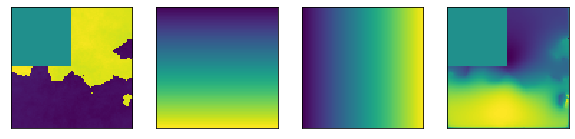

In [200]:
fig = plt.figure(figsize = (10,5))

example = 1

plt.subplot(1,4,1)
plt.imshow(x_train_grids[example,:,:,0], interpolation = 'none')
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,4,2)
plt.imshow(x_train_grids[example,:,:,1], interpolation = 'none')
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,4,3)
plt.imshow(x_train_grids[example,:,:,2], interpolation = 'none')
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,4,4)
plt.imshow(y_train[example], interpolation = 'none')
plt.xticks([],[])
plt.yticks([],[])

# Neural Network

In [201]:
model = Net2d(modes, width).cuda()
print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l2_loss = LpLoss(size_average=True)

5051713


In [202]:
train_loss_arr = []
test_loss_arr = []
def train(epoch):
    model.train()
    start_time = time.perf_counter()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        
        # break the L into 3 parts using narrow and compute loss on each part
        output = model(data)
        
        output = loss_reconstruct(output)
            
        loss = l2_loss(output.view(batch_size, s, s), target.view(batch_size, s, s))

        total_loss += loss.item()

        loss.backward()

        optimizer.step()

#     print('Train Epoch: {} Loss: {:.8E} Time: {:.1f}'.format(
#         epoch,
#         total_loss / len(train_loader.dataset),
#         time.perf_counter() - start_time
#     ))
    
    scheduler.step()
    train_loss_arr.append(total_loss / ntrain)
    
    return(total_loss / len(train_loader.dataset), time.perf_counter() - start_time)


def test():
    model.eval()
    loss = 0
    start_time = time.perf_counter()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            
            # loss += F.mse_loss(output.view(batch_size, -1), target.view(batch_size,-1), reduction = 'sum').item()

            # loss = F.mse_loss(output.view(batch_size,-1), target.view(batch_size,-1), reduction = 'sum')
            
            output = loss_reconstruct(output)
            
            loss += l2_loss(output.view(batch_size, s, s), target.view(batch_size, s, s)).item()
    
    runtime = time.perf_counter() - start_time
    loss /= len(test_loader.dataset)
#     print('Test Loss: {:.8E} Time: {:.1f}'.format(
#         loss,
#         runtime
#     ))
    test_loss_arr.append(loss)
    return loss, runtime

In [203]:
initial_loss, initial_runtime = test()
print(initial_loss, initial_runtime)
for epoch in range(1, epochs+1):
    train_loss, train_time = train(epoch)
    test_loss, test_time = test()
    print('{} {:.8f} {:.3f} {:.8f} {:.3f}'.format(epoch, train_loss, train_time, test_loss, test_time))

1.0071011385321618 0.9143108559946995
1 0.52994898 14.656 0.43692495 0.914
2 0.38797709 14.649 0.32219223 0.912
3 0.31719266 14.657 0.34058037 0.893
4 0.28566155 14.684 0.28953715 0.894
5 0.27046410 14.632 0.24753456 0.893
6 0.25812885 14.647 0.24240041 0.893
7 0.24931980 14.645 0.23437129 0.892
8 0.24682425 14.659 0.23978449 0.894
9 0.23598216 14.660 0.22747425 0.893
10 0.23211390 14.656 0.22833734 0.892
11 0.22788730 14.648 0.25282015 0.894
12 0.22772772 14.668 0.24393208 0.893
13 0.22455123 14.654 0.22969201 0.891
14 0.22042431 14.597 0.22848151 0.889
15 0.21628728 14.582 0.22044496 0.893
16 0.21227776 14.596 0.25261407 0.888
17 0.21277313 14.619 0.21129785 0.897
18 0.21145555 14.673 0.21349161 0.891
19 0.20922037 14.602 0.19707484 0.894
20 0.20867906 14.625 0.21565650 0.892
21 0.18659640 14.657 0.21607849 0.893
22 0.18198469 14.642 0.19444692 0.892
23 0.17894695 16.176 0.18869633 0.914
24 0.17735893 14.739 0.21190835 0.914
25 0.17764799 14.607 0.18074406 0.913
26 0.17479605 14.649 

# Data Analysis

torch.Size([1, 85, 85, 1])


([], [])

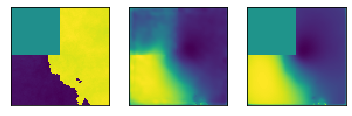

In [208]:
import itertools

index = 3

data, target = next(itertools.islice(test_loader, index, None))
data = data.cuda()
output = model(data)
print(output.shape)
output = output.cpu().detach().numpy()

output = output.reshape((s,s))
target = target.reshape((s,s))

fig = plt.figure()

data = data.cpu().detach().numpy()

plt.subplot(1,3,1)
plt.imshow(data[0,:,:,0], interpolation = 'none')
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,2)
plt.imshow(output, interpolation = 'none')
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,3)
plt.imshow(target, interpolation = 'none')
plt.xticks([],[])
plt.yticks([],[])

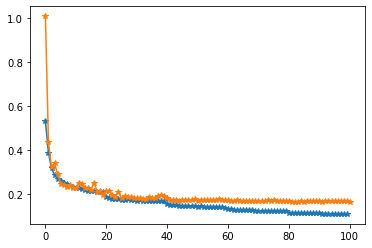

In [205]:
fig = plt.figure()

plt.plot(train_loss_arr, "*-")
plt.plot(test_loss_arr, "*-")
plt.show()